In [51]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import random

base_dir = 'C:/Users/20213002/.vscode/Y3Q3 Project AI MIA'
model_name = 'CVEA_cnn'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'
batch_size = 32
img_size = 96
nr_epochs = 10
split = 0.9
class_type = 0
latent_dim = 100

print('Model name is {}, class {}'.format(model_name, class_type))
print('Parameters-->\n Number of epochs: {}\n Batch size: {}\n Validation split: {}\n Latend dim: {}'.format(nr_epochs, batch_size, split, latent_dim))

Model name is CVEA_cnn, class 0
Parameters-->
 Number of epochs: 10
 Batch size: 32
 Validation split: 0.9
 Latend dim: 100


In [52]:
def get_pcam_generators(base_dir, batch_size_gen=batch_size, class_type=class_type, split=split, img_size=img_size):
    """
    Uses the ImageDataGenerator function from the Keras API to return images in batches,
    train_gen for the training data and val_gen for the validation data.

    Args:
        base_dir (str): Base directory containing the dataset.
        train_batch_size (int): Batch size for training data. Default is 32.
        val_batch_size (int): Batch size for validation data. Default is 32.

    Returns:
        tuple: A tuple containing train_gen and val_gen, both are generators.
    """
    train_folder = 'train_' + str(class_type)
    val_folder = 'valid_' + str(class_type)
    # Dataset parameters
    TRAIN_PATH = os.path.join(base_dir, 'train+val', train_folder)
    VALID_PATH = os.path.join(base_dir, 'train+val', val_folder)
    RESCALING_FACTOR = 1./255
    print(TRAIN_PATH)
    print(VALID_PATH)
    
    # Instantiate data generators
    datagen = ImageDataGenerator(rescale=RESCALING_FACTOR,
                                 validation_split=split)

    # Generate data batches for training and validation sets
    train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size_gen,
                                            subset='training',
                                            classes=[str(class_type)],
                                            class_mode='input')

    val_gen = datagen.flow_from_directory(VALID_PATH,
                                          target_size=(img_size, img_size),
                                          batch_size=batch_size_gen,
                                          subset='validation',
                                          class_mode='input',
                                          classes=[str(class_type)],
                                          shuffle=False)
    return train_gen, val_gen


"""def construct_vae(train_gen, val_gen, weights_filepath, model_name, nr_epochs=1, latent_dim=latent_dim, batch_size=batch_size, img_size=img_size):
    # Define input shape and latent dimension
    input_shape = (img_size, img_size, 3)
    # Encoder network
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    shape_before_flattening = K.int_shape(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Sampling function
    @tf.function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Reparameterization trick
    z = Lambda(sampling)([z_mean, z_log_var])

    # Decoder network
    decoder_input = Input(K.int_shape(z)[1:])
    x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
    x = Reshape(shape_before_flattening[1:])(x)
    x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
    x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
    x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Define the VAE model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_input, x, name='decoder')
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name=model_name)

    # Define the VAE loss function
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
    B = 1000   
    vae_loss = K.mean(B * reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.add_metric(kl_loss, name="kl_loss")
    vae.add_metric(reconstruction_loss, name="reconstruction_loss")
    vae.compile(optimizer='adam')

    model_json = vae.to_json() # serialize model to JSON
    with open(model_name, 'w') as json_file:
        json_file.write(model_json)

    checkpoint = callbacks.ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    tensorboard = callbacks.TensorBoard(log_dir=os.path.join('logs', model_name))
    callbacks_list = [checkpoint, tensorboard]

    train_steps = train_gen.n // train_gen.batch_size
    val_steps = val_gen.n // val_gen.batch_size
    
    vae.fit(train_gen, 
            steps_per_epoch=train_steps, 
            epochs=nr_epochs, 
            batch_size=batch_size, 
            validation_data=val_gen, 
            validation_steps=val_steps,
            callbacks=callbacks_list)
    return vae



def reconstruct_img(vae, val_gen, img_size=img_size):
    decoded_imgs = vae.predict(val_gen)
    # Display the original and reconstructed images

    n = 10 # number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display the original image
        ax = plt.subplot(2, n, i + 1)
        # print(val_gen.shape)
        img, label = val_gen.next()
        plt.imshow(img[0])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()



def generate_new_img(vae, base_dir, class_type=0, num_samples=10, delete_files=True, img_size=img_size):
    random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))
    decoded_imgs = vae.predict(random_latent_vectors)
    # Path to the directory where you want to save the images
    save_dir = base_dir + "/train_new/{}/".format(str(class_type))

    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    for file in os.listdir(save_dir):
        if file.endswith('.jpg') and delete_files == True:
            os.remove(save_dir + file)

    # Iterate through existing images
    for i in range(len(decoded_imgs)):
        img = decoded_imgs[i].reshape(img_size, img_size,3)
        # Generate a random name for the image
        random_name = ''.join(random.choices('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ', k=10))
        # Save the image with the random name and jpg extension
        plt.imsave(os.path.join(save_dir, random_name + ".jpg"), img)

    print("Images saved to:", save_dir)"""

'def construct_vae(train_gen, val_gen, weights_filepath, model_name, nr_epochs=1, latent_dim=latent_dim, batch_size=batch_size, img_size=img_size):\n    # Define input shape and latent dimension\n    input_shape = (img_size, img_size, 3)\n    # Encoder network\n    inputs = Input(shape=input_shape)\n    x = Conv2D(16, (3, 3), activation=\'relu\', padding=\'same\')(inputs)\n    x = Conv2D(32, (3, 3), activation=\'relu\', strides=(2, 2), padding=\'same\')(x)\n    x = Conv2D(128, (3, 3), activation=\'relu\', padding=\'same\')(x)\n    x = Conv2D(256, (3, 3), activation=\'relu\', padding=\'same\')(x)\n    shape_before_flattening = K.int_shape(x)\n    x = Flatten()(x)\n    z_mean = Dense(latent_dim)(x)\n    z_log_var = Dense(latent_dim)(x)\n\n    # Sampling function\n    @tf.function\n    def sampling(args):\n        z_mean, z_log_var = args\n        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))\n        return z_mean + K.exp(z_log_var / 2) * epsilon\n\n    # Reparameteri

In [53]:
def sampling(args):
    # Based on: https://keras.io/examples/generative/vae/
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.) 
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [54]:
def build_encoder(input_layer, latent_dimensions, kernel_size):
    x = Conv2D(64, kernel_size, activation='relu',padding='same',name='encoder-conv2d-64')(input_layer)
    x = MaxPooling2D((2, 2),name='encoder-maxpool1')(x)
    x = Conv2D(32, kernel_size, activation='relu',padding='same',name='encoder-conv2d-32')(x)
    x = MaxPooling2D((2, 2),name='encoder-maxpool2')(x)
    x = Conv2D(16, kernel_size, activation='relu',padding='same',name='encoder-conv2d-16')(x)
    x = MaxPooling2D((2, 2),name='encoder-maxpool3')(x)
    x = Conv2D(8, kernel_size, activation='relu',padding='same',name='encoder-conv2d-8')(x)
    encoder_shape = K.int_shape(x)[1:]
    x = Reshape((np.prod(encoder_shape),),name='encoder-reshape')(x)
    z_mean = Dense(latent_dimensions,activation='linear',name='encoder-z-mean')(x)
    z_log_var = Dense(latent_dimensions, name='encoder-z-log-var',activation='linear')(x)

    # reparameterization trick
    z = Lambda(sampling, output_shape=(latent_dimensions,), name='z')([z_mean, z_log_var])

    model = Model(input_layer, [z_mean, z_log_var, z], name='encoder')
    return model, z_mean, z_log_var, encoder_shape

In [55]:
def build_decoder(latent_dimensions, kernel_size, encoder_shape, input_shape):
    lats = Input(shape=(latent_dimensions,),name='latent')

    x = Dense(np.prod(encoder_shape),activation='relu',name='decoder-dense')(lats)
    x = Reshape(encoder_shape,name='decoder-reshape')(x)
    x = Conv2DTranspose(16, kernel_size, activation='relu',padding='same',name='decoder-conv2d-16')(x)
    x = UpSampling2D((2, 2),name='decoder-upsample1')(x)
    x = Conv2DTranspose(32, kernel_size, activation='relu',padding='same',name='decoder-conv2d-32')(x)
    x = UpSampling2D((2, 2),name='decoder-upsample2')(x)
    x = Conv2DTranspose(64, kernel_size, activation='relu',padding='same',name='decoder-conv2d-64')(x)
    x = UpSampling2D((2, 2),name='decoder-upsample3')(x)
    outputs = Conv2DTranspose(3, kernel_size, activation='relu',padding='same',name='decoder-output')(x)
    
    model = Model(lats, outputs, name='decoder')
    return model

In [56]:
def build_autoencoder(encoder, decoder, input_layer, z_mean, z_log_var, is_rgb):
    output_layer = decoder(encoder(input_layer)[2])
    vae = Model(input_layer, output_layer, name='autoencoder')

    reconstruction_axis = (1,2)
    if is_rgb: reconstruction_axis = (1,2,3)

    reconstruction_loss = tf.reduce_mean(1000.0*tf.square(input_layer-output_layer),axis=reconstruction_axis)
    
    kl_loss =  -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = 1)

    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.add_metric(tf.reduce_sum(1000.0*tf.square(input_layer-output_layer),axis=reconstruction_axis),name='reconstruction_loss',aggregation='mean')
    vae.add_metric(kl_loss,name='kl_loss',aggregation='mean')
    vae.compile(optimizer='adam')

    return vae, reconstruction_loss

In [57]:

model_name = "vae_sunflowers128"
input_shape = (96, 96, 3)
latent_dimensions = 200
batch_size = 32
epochs = 150
kernel_size = 3
input_layer = Input(shape=input_shape, name='encoder_input')
train_gen, val_gen = get_pcam_generators(base_dir, batch_size_gen=batch_size, split=split, class_type=1)

encoder, z_mean, z_log_var, encoder_shape = build_encoder(input_layer, latent_dimensions, kernel_size)
decoder = build_decoder(latent_dimensions, kernel_size, encoder_shape, input_shape)
autoencoder, reconstruction_loss = build_autoencoder(encoder, decoder, input_layer, z_mean, z_log_var, is_rgb=True)

callback_early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,#look at last x epochs
    min_delta=0.01,#loss must improve by this amount
    restore_best_weights=True,
)
callback_checkpoint = callbacks.ModelCheckpoint("checkpoint_"+model_name+".h5", monitor='val_loss', 
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto')
tensorboard = callbacks.TensorBoard(log_dir=os.path.join('logs', model_name))
callbacks_list = [callback_checkpoint, tensorboard, callback_early_stopping]

train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // val_gen.batch_size

autoencoder.fit(train_gen, 
                steps_per_epoch=train_steps, 
                epochs=nr_epochs, 
                batch_size=batch_size, 
                validation_data=val_gen, 
                validation_steps=val_steps,
                shuffle=True,
                callbacks=callbacks_list)
autoencoder.save_weights(model_name+'.h5')

C:/Users/20213002/.vscode/Y3Q3 Project AI MIA\train+val\train_1
C:/Users/20213002/.vscode/Y3Q3 Project AI MIA\train+val\valid_1


Found 7200 images belonging to 1 classes.
Found 7200 images belonging to 1 classes.
Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 56.6693 - reconstruction_loss: 1529904.3750 - kl_loss: 1.3343
Epoch 1: val_loss improved from inf to 43.23144, saving model to checkpoint_vae_sunflowers128.h5
225/225 [==============================] - 156s 684ms/step - loss: 56.6693 - reconstruction_loss: 1529904.3750 - kl_loss: 1.3343 - val_loss: 43.2314 - val_reconstruction_loss: 1132216.2500 - val_kl_loss: 2.2803
Epoch 2/10


c:\Users\20213002\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - ETA: 0s - loss: 40.9373 - reconstruction_loss: 1077762.5000 - kl_loss: 1.9557
Epoch 2: val_loss improved from 43.23144 to 39.74168, saving model to checkpoint_vae_sunflowers128.h5
225/225 [==============================] - 149s 663ms/step - loss: 40.9373 - reconstruction_loss: 1077762.5000 - kl_loss: 1.9557 - val_loss: 39.7417 - val_reconstruction_loss: 1040555.1875 - val_kl_loss: 2.1059
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 40.1510 - reconstruction_loss: 1055012.0000 - kl_loss: 1.9923
Epoch 3: val_loss improved from 39.74168 to 39.70846, saving model to checkpoint_vae_sunflowers128.h5
225/225 [==============================] - 162s 722ms/step - loss: 40.1510 - reconstruction_loss: 1055012.0000 - kl_loss: 1.9923 - val_loss: 39.7085 - val_reconstruction_loss: 1041961.3750 - val_kl_loss: 2.0218
Epoch 4/10
225/225 [==============================] - ETA: 0s - loss: 39.8211 - reconstruction_loss: 1045425.1250 - kl_lo

In [58]:
decoded_imgs = autoencoder.predict(val_gen)

225/225 [==============================] - 36s 160ms/step


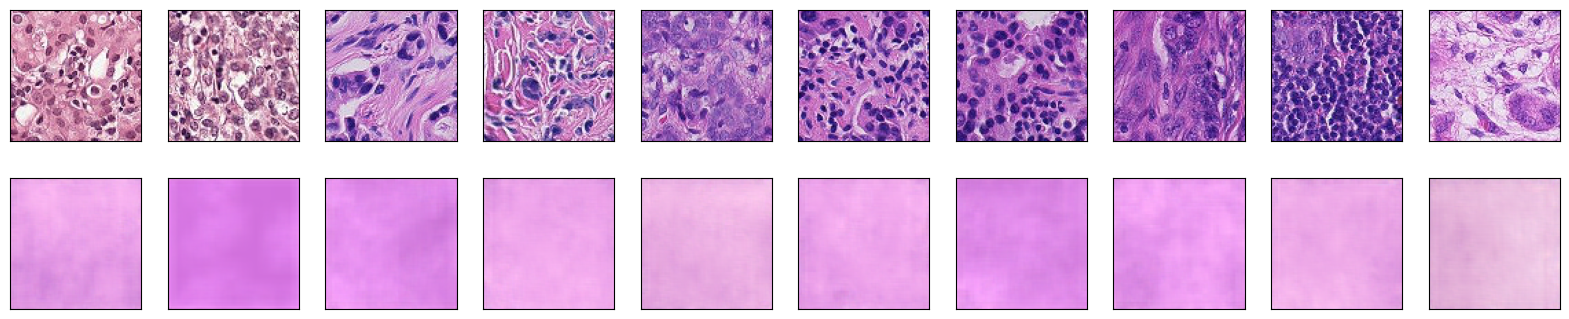

In [59]:
def reconstruct_img(vae, val_gen, img_size=96):
    # Display the original and reconstructed images

    n = 10 # number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display the original image
        ax = plt.subplot(2, n, i + 1)
        # print(val_gen.shape)
        img, label = val_gen.next()
        plt.imshow(img[0])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        image = decoded_imgs[i]/decoded_imgs[i].max()
        plt.imshow(image)
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

reconstruct_img(autoencoder, val_gen)

1/1 [==============================] - 0s 105ms/step
(1, 96, 96, 3)


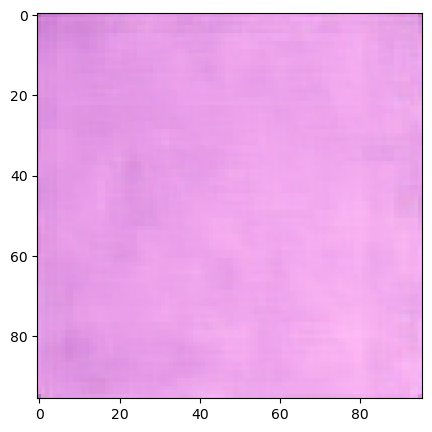

In [60]:

new_image = decoder.predict(np.random.normal(0,1,size=(1,latent_dimensions)))
print(new_image.shape)
plt.figure(figsize=(5, 5))
new_image = new_image.squeeze()/new_image.squeeze().max()
plt.imshow(new_image)
plt.show()

1/1 [==============================] - 0s 43ms/step
(10, 96, 96, 3)


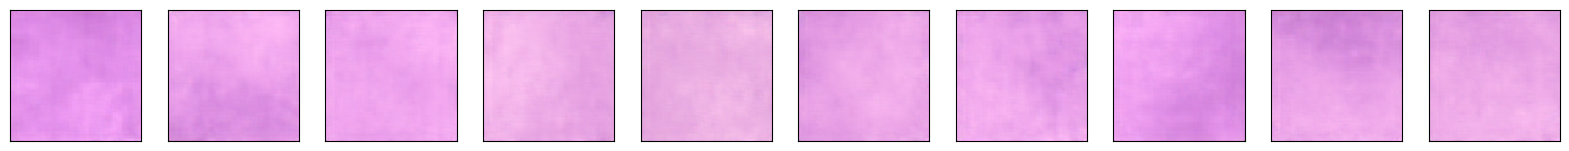

In [61]:
n = 10 # number of images to display

random_vector = np.random.normal(0,1,size=(n,latent_dimensions))
new_image = decoder.predict(random_vector)
print(new_image.shape)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    image = new_image.squeeze()[i]/new_image.squeeze()[i].max()
    plt.imshow(image)
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()